# VAE

In [1]:
# import libraries

import torch
import torch.nn as nn

from torchvision import transforms, datasets
import torch.nn.functional as F
import torch.optim as optim


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# download datasets

# you can also try transforms.ToTensor() + transforms.Normalize(mean, std) with mean = 0.5, std = 0.5, BUT if you do so, instead of nn.Sigmoid() in the model use nn.Tanh()
transform = transforms.ToTensor()

# download data for training
mnist_data = datasets.MNIST(root='./data', train=True,
                            download=True, transform = transform)

# set dataloader
data_loader = torch.utils.data.DataLoader(dataset = mnist_data,
                                          batch_size = 64,
                                          shuffle = True)
# download data for test
test_data = datasets.MNIST(root='./data', train=False,
                            download=True, transform = transform)

In [3]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Output: (32, 28, 28)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 14, 14)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 7, 7)
            nn.ReLU(),
            nn.Flatten(),  # Flatten the conv features to feed them into the linear layers
            nn.Linear(128 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Linear(1024, latent_dim * 2)  # We need 2 * latent_dim for mean and log-variance
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (128, 7, 7)),  # Unflatten to bring back into image dimensions for conv layers
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Sigmoid because MNIST is between [0, 1]
        )
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoding
        x_encoded = self.encoder(x)
        mu, log_var = x_encoded.chunk(2, dim=-1)  # Split the encoded values into mu and log_var components
        
        # Reparameterization trick
        z = self.reparameterize(mu, log_var)
        
        # Decoding
        x_reconstructed = self.decoder(torch.Tensor(z))
        
        return x_reconstructed, mu, log_var

# Loss function for VAE
def vae_loss(reconstructed_x, x, mu, logvar):
    x = x.view(-1, 1, 28, 28)
    reconstructed_x = reconstructed_x.view(-1, 1, 28, 28)

    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [258]:
device = 'mps'

latent_dim = 6
conv_vae = ConvVAE(latent_dim).to(device)

optimizer = optim.Adam(conv_vae.parameters(), lr=1e-3)

mnist_data = datasets.MNIST(root='./data', train=True,
                            download=True, transform = transform)

# set dataloader
mnist_loader = torch.utils.data.DataLoader(dataset = mnist_data,
                                          batch_size = 64,
                                          shuffle = True)
# download data for test
test_data = datasets.MNIST(root='./data', train=False,
                            download=True, transform = transform)

# Training loop
epochs = 10
for epoch in tqdm(range(epochs)):
    loss = 0
    for batch_idx, (data, _) in enumerate(mnist_loader):
        # Move data to the device
        data = data.to(device)

        # Forward pass
        reconstructed_images, mu, logvar = conv_vae(data)

        # Compute loss
        loss = vae_loss(reconstructed_images, data, mu, logvar)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch_idx % 100 == 0:
        #     print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(mnist_loader.dataset)} "
        #           f"({100. * batch_idx / len(mnist_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}")
    print(f'Epoch {epoch}, Loss: {loss}')

    # Perform any validation/testing you want to do at the end of each epoch

# Save the trained model
torch.save(conv_vae.state_dict(), 'conv_vae_mnist.pth')

print("Training complete")

 10%|█         | 1/10 [00:23<03:31, 23.48s/it]

Epoch 0, Loss: 3869.55859375


 20%|██        | 2/10 [00:47<03:10, 23.79s/it]

Epoch 1, Loss: 4010.010986328125


 30%|███       | 3/10 [01:10<02:44, 23.43s/it]

Epoch 2, Loss: 3596.461669921875


 40%|████      | 4/10 [01:33<02:19, 23.18s/it]

Epoch 3, Loss: 3404.070556640625


 50%|█████     | 5/10 [01:56<01:55, 23.07s/it]

Epoch 4, Loss: 3252.35107421875


 60%|██████    | 6/10 [02:18<01:31, 22.96s/it]

Epoch 5, Loss: 3291.83251953125


 70%|███████   | 7/10 [02:41<01:08, 22.93s/it]

Epoch 6, Loss: 3298.16943359375


 80%|████████  | 8/10 [03:04<00:45, 22.89s/it]

Epoch 7, Loss: 3481.9375


 90%|█████████ | 9/10 [03:27<00:22, 22.84s/it]

Epoch 8, Loss: 3645.217041015625


100%|██████████| 10/10 [03:50<00:00, 23.03s/it]

Epoch 9, Loss: 3388.91357421875
Training complete


In [4]:
latent_dim = 20
conv_vae = ConvVAE(latent_dim).to('cpu')
conv_vae.load_state_dict(torch.load('conv_vae_mnist.pth', map_location='cpu'))

<All keys matched successfully>

In [5]:
mnist_loader = torch.utils.data.DataLoader(dataset = mnist_data,
                                          batch_size = 64,
                                          shuffle = True)

# TRAIN AND TEST VAE

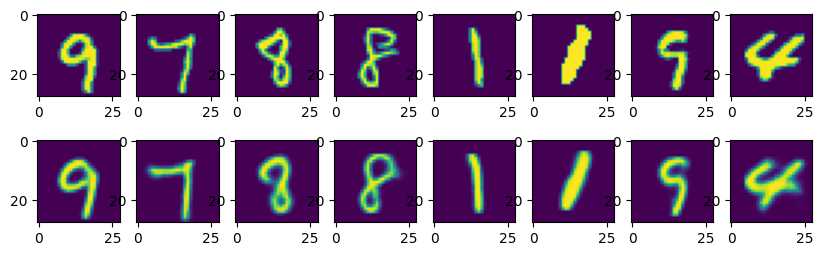

In [6]:
conv_vae.eval()

# Assuming 'test_data' is your MNIST test dataset
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)

conv_vae.to('cpu')

data = torch.Tensor(next(iter(test_loader))[0]).to('cpu')


# Forward pass through the model
with torch.no_grad():
    reconstructed_images, _, _ = conv_vae(data)

recov = []
origin = []
for i in range(8):
  origin.append(data[i].reshape(28,28))
  recov.append(reconstructed_images[i].reshape(28,28))

fig, ax = plt.subplots(nrows=2, ncols =8, figsize=(10,3))

for i in range(8):
  ax[0,i].imshow(origin[i].squeeze())
  ax[1,i].imshow(recov[i])

In [84]:
print(conv_vae.encoder.modules)
print(conv_vae.decoder.modules)

<bound method Module.modules of Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=6272, out_features=1024, bias=True)
  (8): ReLU()
  (9): Linear(in_features=1024, out_features=40, bias=True)
)>
<bound method Module.modules of Sequential(
  (0): Linear(in_features=20, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=6272, bias=True)
  (3): ReLU()
  (4): Unflatten(dim=1, unflattened_size=(128, 7, 7))
  (5): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (6): ReLU()
  (7): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (8): ReLU()
  (9): ConvTranspose2d(32, 1,

In [138]:
activations_encoder = {
    'layer1' : None, 
    'layer2' : None, 
    'layer3' : None, 
    'layer4' : None,
}

activations_decoder = {
    'layer1' : None, 
    'layer2' : None, 
    'layer3' : None, 
    'layer4' : None,
}
# activations_encoder = {}
def get_activation_foo(name, activations):
    def hookFoo(model, input, output):
        if activations[name] == None: 
            activations[name] = output.detach()
        else:
            activations[name] = torch.cat((activations[name], output.detach()), 0)
    return hookFoo

def get_activation_foo_input(name, activations):
    def hookFoo(model, input, output):
        if activations[name] == None: 
            activations[name] = input[0].detach()
        else:
            activations[name] = torch.cat((activations[name], input[0].detach()), 0)
    return hookFoo

conv_vae.encoder[0].register_forward_hook(get_activation_foo('layer1', activations_encoder))
conv_vae.encoder[2].register_forward_hook(get_activation_foo('layer2', activations_encoder))
conv_vae.encoder[4].register_forward_hook(get_activation_foo('layer3', activations_encoder))
conv_vae.encoder[9].register_forward_hook(get_activation_foo('layer4', activations_encoder))

conv_vae.decoder[0].register_forward_hook(get_activation_foo_input('layer1', activations_decoder))
conv_vae.decoder[5].register_forward_hook(get_activation_foo_input('layer2', activations_decoder))
conv_vae.decoder[7].register_forward_hook(get_activation_foo_input('layer3', activations_decoder))
conv_vae.decoder[9].register_forward_hook(get_activation_foo_input('layer4', activations_decoder))

In [31]:
activations_encoder['layer1'].shape

torch.Size([3136, 32, 28, 28])

In [ ]:
activations_encoder['layer1'][0, 0]

In [30]:
activations_encoder.keys()

dict_keys(['layer1', 'layer2', 'layer3', 'layer4'])

In [20]:
conv_vae.encoder

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=6272, out_features=1024, bias=True)
  (8): ReLU()
  (9): Linear(in_features=1024, out_features=40, bias=True)
)

In [ ]:
for batch_idx, (data, _) in enumerate(mnist_loader):
        with torch.no_grad():
                reconstructed_images, mu, logvar = conv_vae(data)

In [ ]:
for key in activations_encoder.keys():
    layer_conv_result = activations_encoder[key]
    avg_img_per_layer = []

    for img in layer_conv_result:
        if len(img.shape) == 1:
            avg_img_per_layer.append(img.numpy())
        else:
            print(img.size())
            print(torch.mean(img, dim=[1,2]).numpy())
            avg_img_per_layer.append(torch.mean(img, dim=[1,2]).numpy())
    
    data_encoder_20_dim_tmp = pd.DataFrame(avg_img_per_layer)

    if key == list(activations_encoder.keys())[0]:
        data_encoder_20_dim = data_encoder_20_dim_tmp
    else:
        data_encoder_20_dim = pd.concat([data_encoder_20_dim, data_encoder_20_dim_tmp], axis=1)

Encode feature maps to vector with average pooling

In [149]:
def extract_features(model_vae, data):
    features_enc_batch, features_dec_batch = [], []
    with torch.no_grad():
        for i in range(data.shape[0]):
            reconstructed_images, mu, logvar = model_vae(data)
            for key_enc, key_dec in zip(activations_encoder.keys(), activations_decoder.keys()):
                # layer_conv_result_enc, layer_conv_result_dec = activations_encoder[key_enc][-1], activations_decoder[key_dec][-1]
                img_enc, img_dec = activations_encoder[key_enc][-1], activations_decoder[key_dec][-1]
                # print(img_enc.shape)
                print(len(activations_encoder[key_enc]))
                avg_img_per_layer_enc, avg_img_per_layer_dec = [], []

                # print(layer_conv_result_enc.size())
                # print(layer_conv_result_enc.shape)
                # for img_enc, img_dec in zip(layer_conv_result_enc, layer_conv_result_dec):
                if len(img_enc.shape) == 1:
                    avg_img_per_layer_enc.append(img_enc.numpy())
                else:
                    # print(img_enc.size())
                    # print(torch.mean(img_enc, dim=[0,1]).numpy())
                    avg_img_per_layer_enc.append(torch.mean(img_enc, dim=[1,2]).numpy())

                if len(img_dec.shape) == 1:
                    avg_img_per_layer_dec.append(img_dec.numpy())
                else:
                    avg_img_per_layer_dec.append(torch.mean(img_dec, dim=[1,2]).numpy())
                    
                
                features_tmp_enc, features_tmp_dec = pd.DataFrame(avg_img_per_layer_enc), pd.DataFrame(avg_img_per_layer_dec)

                if key_enc == list(activations_encoder.keys())[0]:
                    features_concat_enc, features_concat_dec = features_tmp_enc, features_tmp_dec
                else:
                    features_concat_enc, features_concat_dec = pd.concat([features_concat_enc, features_tmp_enc], axis=1), pd.concat([features_concat_dec, features_tmp_dec], axis=1)
            features_enc_batch.append(features_concat_enc), features_dec_batch.append(features_concat_dec)
            
    return features_enc_batch, features_dec_batch

## Train Simple Neural Net

In [150]:
from smallnet import LinearNet, Net, split_dataset
from torch.utils.data import DataLoader, Dataset, Subset

In [151]:
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 2*x - 1)  # Normalize MNIST data
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_indices, test_indices = split_dataset(train_dataset, num_train_per_class=32, num_test_per_class=64)

train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size)

In [152]:
def train_model(train_loader, model, criterion, optimizer, model_vae, epochs=90, loss_list=[]):
    model.train()
    loss_list = []
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            features_enc, features_dec = extract_features(model_vae, images)
            print(images.shape)
            print(features_enc.shape)
            features_enc_tensor = torch.tensor(features_enc[:10000].to_numpy())
            outputs = model(features_enc_tensor)
            optimizer.zero_grad()
            # print(labels.shape)
            # print(outputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_list.append(running_loss / len(train_loader))
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
    return loss_list


def test_model(model, test_loader, model_vae):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            features_enc, features_dec = extract_features(model_vae, images)
            features_enc_tensor = torch.tensor(features_enc[:10000].to_numpy())
            outputs = model(features_enc_tensor)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy}%")
    return accuracy

In [153]:
input_size = 264
num_classes = 10
epochs = 90
t_up = 50

batch_size = 64

loss_list = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model_vae = conv_vae

loss_list = train_model(train_loader, model, criterion, optimizer, model_vae, epochs=epochs)
accuracy = test_model(model, test_loader, model_vae)
accuracy

64
64
64
64
128
128
128
128
192
192
192
192
256
256
256
256


KeyboardInterrupt: 